In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import math
import tensorflow as tf
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool, Process, Manager


2023-03-29 10:12:30.147781: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/packages/7x/anaconda3/5.3.0/envs/tf2.4.1-gpu/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import os
import numpy as np
from keras_preprocessing.image import ImageDataGenerator, NumpyArrayIterator
DATA_DIR = '/scratch/dshah47/imageClassification/data1/'

TRAIN_DIR = '/scratch/dshah47/imageClassification/data1/train/'
TEST_DIR = '/scratch/dshah47/imageClassification/data1/test/'

train_df = pd.read_csv(f'{DATA_DIR}/train_label.txt', sep=' ', header=None)
train_df.columns = ['filenames', 'labels']
trainLabels = dict(zip(train_df.filenames,train_df.labels))

test_df = pd.read_csv(f'{DATA_DIR}/test_label.txt', sep=' ', header=None)
test_df.columns = ['filenames', 'labels']
testLabels = dict(zip(test_df.filenames,test_df.labels))

In [3]:
# Load train data
train_data = []
train_labels = []

def f(train, images):
    for filename in images:
        if filename.endswith('.npy'):
            arr = np.load(os.path.join(TRAIN_DIR, filename))
            data = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
            data = cv2.resize(data, dsize=(75, 75), interpolation=cv2.INTER_CUBIC)
            label = int(trainLabels[filename])  # Assuming filename format is 'image_<label>.npy'
            # train_data.append(data)
            # train_labels.append(label)
            train.append([data, label])

with Manager() as manager:
    train = manager.list() 
    processes = []
    for i in range(0, 50000, 5000):
        p = Process(target=f, args=(train, os.listdir(TRAIN_DIR)[i:i+5000]))  # Passing the list
        p.start()
        processes.append(p)
    for p in processes:
        p.join()

    train_data, train_labels = zip(*train)
    
train_data = np.array(train_data)#, axis=0)
train_labels = np.array(train_labels)

# Load test data
test_data = []
test_labels = []
def f(test, images):
    for filename in images:
        if filename.endswith('.npy'):
            arr = np.load(os.path.join(TEST_DIR, filename))
            data = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
            data = cv2.resize(data, dsize=(75, 75), interpolation=cv2.INTER_CUBIC)
            label = int(testLabels[filename])  # Assuming filename format is 'image_<label>.npy'
            # test_data.append(data)
            # test_labels.append(label)
            test.append([data, label])
            

with Manager() as manager:
    test = manager.list() 
    processes = []
    for i in range(0, 10000, 2500):
        p = Process(target=f, args=(test, os.listdir(TEST_DIR)[i:i+2500]))  # Passing the list
        p.start()
        processes.append(p)
    for p in processes:
        p.join()

    test_data, test_labels = zip(*test)
    
test_data = np.array(test_data)#, axis=0)
test_labels = np.array(test_labels)

In [4]:
# Create data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = NumpyArrayIterator(train_data, train_labels,
                                     image_data_generator=train_datagen,
                                     batch_size=128,
                                     shuffle=True)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = NumpyArrayIterator(test_data, test_labels,
                                    image_data_generator=test_datagen,
                                    batch_size=14,
                                    shuffle=True)


In [5]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Load InceptionV3 model
base_model = InceptionV3(input_tensor = Input(shape=(75, 75, 3)), include_top=False)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Build final model
model = Model(inputs=base_model.input, outputs=predictions)

# for layer in model.layers[:249]:
#     layer.trainable = False
# for layer in model.layers[249:]:
#     layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# # Freeze layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=50, validation_data=test_generator)


2023-03-29 10:13:26.592579: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-29 10:13:26.594483: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-29 10:13:27.571581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2023-03-29 10:13:27.571619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-29 10:13:27.575719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-29 10:13:27.575770: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Epoch 1/50


2023-03-29 10:13:34.082048: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-29 10:13:34.287613: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


391/391 [==============================] - 70s 162ms/step - loss: 2.3423 - accuracy: 0.1056 - val_loss: 2.3575 - val_accuracy: 0.1256
Epoch 2/50
391/391 [==============================] - 56s 143ms/step - loss: 2.2816 - accuracy: 0.1383 - val_loss: 2.2718 - val_accuracy: 0.1712
Epoch 3/50
391/391 [==============================] - 56s 143ms/step - loss: 1.2228 - accuracy: 0.5640 - val_loss: 1.3175 - val_accuracy: 0.5430
Epoch 48/50
391/391 [==============================] - 56s 143ms/step - loss: 1.2148 - accuracy: 0.5664 - val_loss: 1.3183 - val_accuracy: 0.5453
Epoch 49/50
391/391 [==============================] - 56s 143ms/step - loss: 1.2085 - accuracy: 0.5662 - val_loss: 1.3144 - val_accuracy: 0.5485
Epoch 50/50
391/391 [==============================] - 56s 143ms/step - loss: 1.2068 - accuracy: 0.5667 - val_loss: 1.2940 - val_accuracy: 0.5501


In [6]:
pd.DataFrame(history.history).to_csv("InceptionV3_50.csv")

In [7]:
model.save("InceptionV3_50.h5")

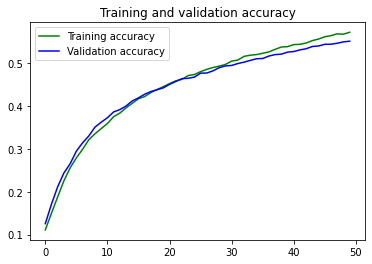

<Figure size 432x288 with 0 Axes>

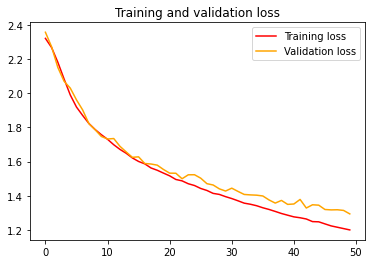

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.legend(loc=0)
plt.savefig("AccuracyInceptionV3_50.png")
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')

plt.legend(loc=0)
plt.savefig("LossInceptionV3_50.png")
plt.figure()
plt.show()
     

100%|██████████| 715/715 [00:26<00:00, 27.20it/s]


Classification Report


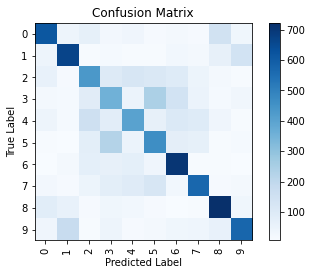

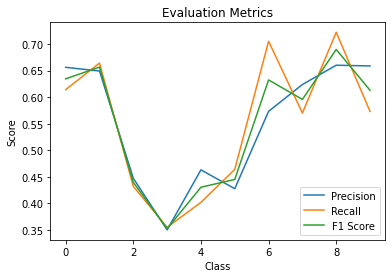

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
num_classes = 10
class_names = list(range(10))

# # Make predictions
y_pred_classes = []
true_classes = []
# Make predictions
for _ in tqdm(range(len(test_generator))):
    data = test_generator.next()
    y_pred = model.predict(data[0])
    y_pred_classes += np.argmax(y_pred, axis=1).tolist()
    true_classes += data[1].tolist()
# Print classification report
print('Classification Report')
report = classification_report(true_classes, y_pred_classes, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report.to_csv("classificationReportInceptionV3_50.csv")

# Plot confusion matrix
cm = confusion_matrix(true_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusionMatrixInceptionV3_50.png')
plt.show()

# Calculate precision, recall, and F1 score
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
# Plot precision, recall, and F1 score
plt.plot(class_names, precision, label='Precision')
plt.plot(class_names, recall, label='Recall')
plt.plot(class_names, f1_score, label='F1 Score')
plt.legend()
plt.title('Evaluation Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.savefig('evaluationMetricsInceptionV3_50.png')
plt.show()
